# <u>収集したデータでモデルを学習</u>
#### 今回収集したデータは以下のように，「センサーid」，「被験者番号」，「行動番号」，「何試行目か」が分かるように以下のようにファイル名を変更している．推定時で新規ファイルを入力する際は，ファイル名を変更する必要はない．
#### 例）id0?\_s0?\_a0?_r0?.csv


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import scipy.signal as sig
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import pickle

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#データファイルのパス
path = os.getcwd()
path = path+'/data_imu/id*_s*_a*_r*.csv'

#filesには全データファイルが格納されている
files = sorted(glob.glob(path))

#被験者1,2,4は一部のデータファイルが取得されてなかったので除外
#files = list(filter(lambda x: 's01' not in x, files)) 
#files = list(filter(lambda x: 's02' not in x, files))
#files = list(filter(lambda x: 's04' not in x, files))

### 使用したいセンサ位置を指定
 ("files"前のコメントアウトを外すとその位置のデータは学習データに用いられない)

In [3]:
#センサid01(右手首)
#files = list(filter(lambda x: 'id01' not in x, files))

#センサid02(左手首)
#files = list(filter(lambda x: 'id02' not in x, files))

#センサid03(右足首)
#files = list(filter(lambda x: 'id03' not in x, files))

#センサid04(左足首)
#files = list(filter(lambda x: 'id04' not in x, files))

#センサid05(腰の中央)
#files = list(filter(lambda x: 'id05' not in x, files))

### 前処理

In [4]:
#imuから取得されたデータのカラム名を指定
header=[
    'index',
    'mag_x','mag_y','mag_z',
    'acc_x','acc_y','acc_z',
    'gyro_x','gyro_y','gyro_z',
    'qw','qx','qy','qz'
]

#収集したデータのサンプリングレート(Hz)
collected_sr = 200
#変更後のサンプリングレート．100Hzに変更する．　
change_sr = 100
#間引き係数算出
decimate_factor = collected_sr/change_sr


#各ファイルを読み込み，それぞれで処理を行う
ids= []
subjects = []
actions = []
trials = []
all_data = []
for file in files:
    data = pd.read_csv(file, header=None, skiprows=10, names=header) 
    #上で指定したサンプリングレートにダウンサンプリング
    data = data.iloc[::int(decimate_factor)]

    #全てのデータファイルをall_dataに格納
    all_data.append(data)
    #「センサーid」をidsに格納
    ids.append(str(file[-18:-16]))
    #「被験者番号」をsubjectsに格納
    subjects.append(str(file[-14:-12]))
    #「行動番号」をactionsに格納
    actions.append(str(file[-10:-8]))
    #「何試行目か」をtrialsに格納
    trials.append(str(file[-6:-4]))
    

In [5]:
#使用するデータ（カラム）を指定
use_data=[
    'acc_x','acc_y','acc_z',
    'gyro_x','gyro_y','gyro_z',
    'qw','qx','qy','qz'
]

#特徴量の数．最後の数字は何種の特徴量を用いるか
nfeats = len(use_data)*5
x = np.empty((0,nfeats))


#各センサごとに1ファイルずつ読み込んで特徴量抽出を行う
count =0
for data in all_data:
    count += 1
    #使用しないカラムを削除
    data = data.drop(['index','mag_x','mag_y','mag_z'],axis=1)
    data = data.replace('        NaN',0.0)
    data = data.replace('NaN',0.0)
    
    #特徴量抽出
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)
    var_data = np.var(data, axis=0)
    max_data = np.max(data,axis=0)
    min_data = np.min(data,axis=0)
    
    
    features = np.empty((1,0))
    features = np.append(features, mean_data)
    features = np.append(features, std_data)
    features = np.append(features, var_data)
    features = np.append(features, max_data)
    features = np.append(features, min_data)
    
    
    #1ファイルを一行に変換する
    if len(features) == nfeats:    
        x = np.vstack((x, features.reshape(1,len(features)))) #vstackは配列を結合する
    else:
       #エラーがあった場合は，ファイルのindexを取得し削除する
        error_index = count-1
        ids.pop(error_index)
        subjects.pop(error_index)
        actions.pop(error_index)
        trials.pop(error_index)
        print(files[error_index])
        

In [6]:
#各センサのデータを1つに結合
num_feats = nfeats*int(len(list(set(ids))))  #最後の数字は使用するセンサの数
X = np.empty((0,num_feats))
subs = []
acts = []
rs= []
all_sensors =[]

for sub in sorted(list(set(subjects))):
    for act in sorted(list(set(actions))):
        for r in sorted(list(set(trials))):
            st = list(filter(lambda x:'s'+sub+'_a'+act+'_r'+r  in x, files))
            for i in range(len(st)):
                all_sensors.extend(x[files.index(st[i])])                
            
            X = np.vstack((X, np.array(all_sensors)))
            all_sensors =[]
            
            subs.append(sub)
            acts.append(act)
            rs.append(r)
    
y = np.asarray(acts)

### パラメメータチューニング
代表的なチューニング方法の<font color="Red">グリッドサーチ</font>を用いてチューニング

#トレーニングデータ、テストデータの分離
train_X, test_X, train_y, test_y = train_test_split(X, y,random_state=0)

#条件設定
max_score = 0
SearchMethod = 0
RFC_grid = {RandomForestClassifier(): {"n_estimators": [i for i in range(1, 50)],
                                       "criterion": ["gini", "entropy"],
                                       "max_depth":[i for i in range(1, 10)],
                                       "random_state": [i for i in range(0, 101)]
                                      }}

#ランダムフォレストの実行
for model, param in tqdm(RFC_grid.items()):
    clf = GridSearchCV(model, param,cv=3)
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    score = f1_score(test_y, pred_y, average="micro")

    if max_score < score:
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__

print("ベストスコア:{}".format(max_score))
print("モデル:{}".format(best_model))
print("パラメーター:{}".format(best_param))

#ハイパーパラメータを調整しない場合との比較
model = RandomForestClassifier()
model.fit(train_X, train_y)
score = model.score(test_X, test_y)
print("")
print("デフォルトスコア:", score)

### モデル学習&テスト

*Accuracy* train: 1.0 test: 0.9545454545454546
             precision    recall  f1-score   support

         01       1.00      1.00      1.00         2
         02       1.00      1.00      1.00         2
         03       1.00      1.00      1.00         2
         04       0.67      1.00      0.80         2
         05       1.00      0.50      0.67         2
         06       1.00      1.00      1.00         2
         07       1.00      1.00      1.00         2
         08       1.00      1.00      1.00         2
         09       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         2
         11       1.00      1.00      1.00         2

avg / total       0.97      0.95      0.95        22



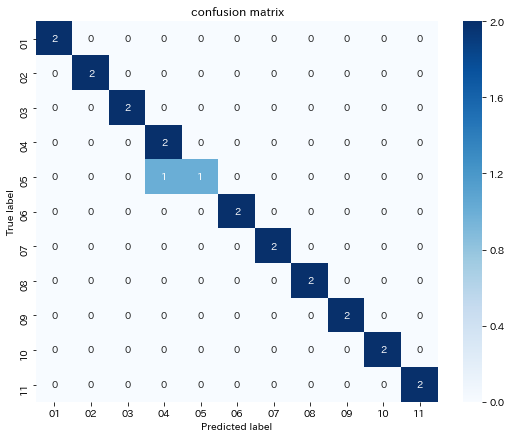

-----------
*Accuracy* train: 1.0 test: 0.8636363636363636
             precision    recall  f1-score   support

         01       1.00      1.00      1.00         2
         02       1.00      1.00      1.00         2
         03       1.00      1.00      1.00         2
         04       1.00      0.50      0.67         2
         05       1.00      1.00      1.00         2
         06       0.67      1.00      0.80         2
         07       1.00      1.00      1.00         2
         08       1.00      1.00      1.00         2
         09       0.00      0.00      0.00         2
         10       1.00      1.00      1.00         2
         11       0.50      1.00      0.67         2

avg / total       0.83      0.86      0.83        22



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


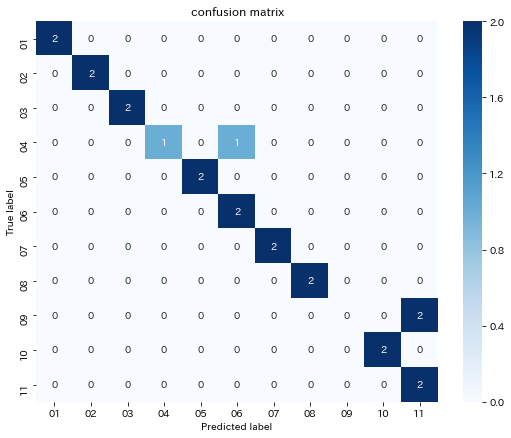

-----------
*Accuracy* train: 1.0 test: 0.9545454545454546
             precision    recall  f1-score   support

         01       1.00      1.00      1.00         2
         02       1.00      1.00      1.00         2
         03       1.00      1.00      1.00         2
         04       1.00      0.50      0.67         2
         05       0.67      1.00      0.80         2
         06       1.00      1.00      1.00         2
         07       1.00      1.00      1.00         2
         08       1.00      1.00      1.00         2
         09       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         2
         11       1.00      1.00      1.00         2

avg / total       0.97      0.95      0.95        22



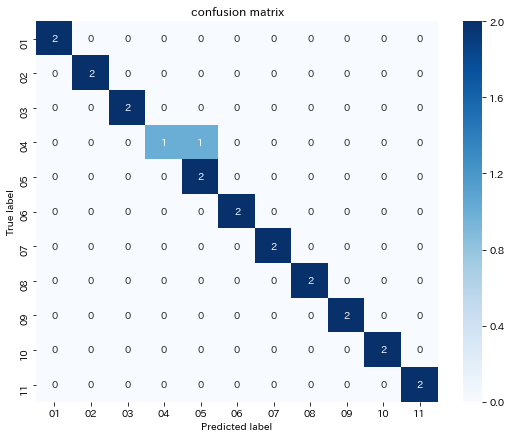

-----------
*test_ave* 0.9242424242424243


In [7]:
#モデルを学習する
#leave one subject out　
logo = LeaveOneGroupOut()
clf = RandomForestClassifier(max_depth=5, n_estimators=42)
#clf = RandomForestClassifier()
accuracy = [] 
    
for train_index, test_index in logo.split(X, y, subs):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)
    accuracy.append(acc_test)
       
    y_pred = clf.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)
    print("*Accuracy* train:",acc_train, "test:",acc_test)
    print(classification_report(y_test, y_pred))
    labels = ["01","02","03","04","05","06","07","08","09","10","11"]

    df_conf = pd.DataFrame(conf, index=labels, columns=labels)
    plt.figure(figsize=(9,7))
    sns.heatmap(df_conf,cmap='Blues',annot=True)
    plt.title('confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
   
    print("-----------")
print("*test_ave*",sum(accuracy)/len(accuracy))

### 学習済みモデルを保存

In [8]:
# モデルを保存名を設定.　同フォルダ内に設定した名前でモデルが保存される．
filename = 'trained_model.sav'
pickle.dump(clf, open(filename, 'wb'))
print("Model Saved!")

Model Saved!
